# Jupyter notebook analyzing synaptic properties of GluA1, GluA4, Stg, PSD95, and NR1 in 2023.10 Stg KO TRN dataset

Last edited by MES on 9/13/24

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy import stats
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [4]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/2023.10_StgKO/'

In [5]:
filenames = os.listdir(parentdir)
csvs = [filename for filename in filenames if filename.endswith('csv')]

In [6]:
csvs

['StgKO_synaptic_protein_quantification_v1_tidytable.csv',
 'trn_synapse_data_combined.csv',
 'ctx_synapse_data_combined.csv',
 'ctx_KOvsCtrl_selectedsynapses_lmer_pvals.csv',
 'TRN_group1vs2_lmer_pvals.csv',
 'trn_KOvsCtrl_selectedsynapses_lmer_pvals.csv',
 'ctx_group1vs2_lmer_pvals.csv']

In [7]:
mats = [filename for filename in filenames if filename.endswith('mat')]

In [8]:
mats

['analyzed_data_trn_nofilt_20240908.mat',
 'analyzed_data_ctx_nofilt_20240907.mat',
 'analyzed_data_trn_nofilt_ztrim_20240913.mat',
 'analyzed_data_ctx_nofilt_ztrim_20240912.mat']

In [10]:
matfile = sio.loadmat('analyzed_data_trn_nofilt_ztrim_20240913.mat',squeeze_me=True)

In [11]:
sorted(matfile.keys())

['__globals__', '__header__', '__version__', 'data']

In [12]:
matdata = matfile['data']

In [13]:
matdata

array((array(['mouseA-ROI1-2_NR1_syn1', 'mouseA-ROI1-2_NR1_syn2',
       'mouseA-ROI1-2_NR1_syn3', ..., 'mouseG-ROI5_NR1_syn122',
       'mouseG-ROI5_NR1_syn123', 'mouseG-ROI5_NR1_syn124'], dtype=object), array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 7.24391766e-05, 0.00000000e+00, 9.05489707e-04,
        8.02867540e-04],
       [0.00000000e+00, 1.32805157e-05, 0.00000000e+00, 3.88756914e-04,
        3.38049491e-05]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0. 

In [14]:
names = matdata['names'].item().tolist()

In [15]:
vols = matdata['total_vol'].item()

In [16]:
ints = matdata['mean_int'].item()

In [17]:
ns = matdata['npuncta'].item()

In [18]:
ints_refnorm = matdata['mean_int_refnorm'].item()

In [19]:
selected_tfs = matdata['selected_tf'].item()

In [20]:
data_array = np.concatenate((vols,ints,ints_refnorm), axis=1)

In [21]:
data_array.shape

(20422, 15)

In [22]:
#protein order: GluA4, Stg, GluA1, PSD95, GluA3, NR1

In [23]:
data = pd.DataFrame(data_array,index=names,
                    columns=['GluA4_vol','GluA3_vol','Stg_vol','PSD95_vol','NR1_vol',
                            'GluA4_meanint','GluA3_meanint','Stg_meanint','PSD95_meanint','NR1_meanint',
                             'GluA4_meanint_refnorm','GluA3_meanint_refnorm','Stg_meanint_refnorm','PSD95_meanint_refnorm','NR1_meanint_refnorm',
                            ])

In [24]:
data.tail(10)

,GluA4_vol,GluA3_vol,Stg_vol,PSD95_vol,NR1_vol,GluA4_meanint,GluA3_meanint,Stg_meanint,PSD95_meanint,NR1_meanint,GluA4_meanint_refnorm,GluA3_meanint_refnorm,Stg_meanint_refnorm,PSD95_meanint_refnorm,NR1_meanint_refnorm
mouseG-ROI5_NR1_syn115,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
mouseG-ROI5_NR1_syn116,0.000094,0.000642,0.0,0.002208,0.001238,7.884615,22.287594,0.0,38.699289,16.249756,0.225688,9.831675,0.0,58.690713,13.810945
mouseG-ROI5_NR1_syn117,0.000000,0.000037,0.0,0.000546,0.000746,0.000000,13.612903,0.0,40.050885,15.422330,0.000000,0.349917,0.0,15.010779,7.902985
mouseG-ROI5_NR1_syn118,0.000000,0.000007,0.0,0.000033,0.000011,0.000000,12.833333,0.0,22.444444,11.000000,0.000000,0.063847,0.0,0.502488,0.082090
mouseG-ROI5_NR1_syn119,0.000041,0.000013,0.0,0.000816,0.000522,8.000000,19.000000,0.0,32.409763,17.347222,0.229730,0.173300,0.0,18.166667,6.213930
mouseG-ROI5_NR1_syn120,0.000002,0.000100,0.0,0.000012,0.000011,15.500000,14.698795,0.0,25.500000,9.222222,0.026863,1.011609,0.0,0.211443,0.068823
mouseG-ROI5_NR1_syn121,0.000004,0.000252,0.0,0.000974,0.000000,12.666667,21.942584,0.0,31.022305,0.000000,0.017552,3.802653,0.0,20.758706,0.000000
mouseG-ROI5_NR1_syn122,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
mouseG-ROI5_NR1_syn123,0.000000,0.000072,0.0,0.000905,0.000803,0.000000,9.433333,0.0,28.196000,16.276692,0.000000,0.469320,0.0,17.534826,8.975124
mouseG-ROI5_NR1_syn124,0.000000,0.000013,0.0,0.000389,0.000034,0.000000,8.363636,0.0,27.968944,15.000000,0.000000,0.076285,0.0,7.467662,0.348259


In [25]:
data.shape

(20422, 15)

In [26]:
data.head(5)

,GluA4_vol,GluA3_vol,Stg_vol,PSD95_vol,NR1_vol,GluA4_meanint,GluA3_meanint,Stg_meanint,PSD95_meanint,NR1_meanint,GluA4_meanint_refnorm,GluA3_meanint_refnorm,Stg_meanint_refnorm,PSD95_meanint_refnorm,NR1_meanint_refnorm
mouseA-ROI1-2_NR1_syn1,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
mouseA-ROI1-2_NR1_syn2,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
mouseA-ROI1-2_NR1_syn3,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
mouseA-ROI1-2_NR1_syn4,0.002783,0.001589,0.0019,0.002912,0.00231,76.604772,28.112462,24.1277,169.839967,25.209618,28.1797,58.353312,59.900631,646.141956,76.066246
mouseA-ROI1-2_NR1_syn5,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


In [27]:
data['selected_tf'] = selected_tfs

In [28]:
#How many synapses were selected?
data['selected_tf'].value_counts()

selected_tf
0    20154
1      268
Name: count, dtype: int64

## 1. Add metadata

In [29]:
groupdict = {
    'A':'Ctrl',
    'B':'Ctrl',
    'D':'Ctrl',
    'E':'KO',
    'F':'KO',
    'G':'KO'
}

In [30]:
data.head(3)

,GluA4_vol,GluA3_vol,Stg_vol,PSD95_vol,NR1_vol,GluA4_meanint,GluA3_meanint,Stg_meanint,PSD95_meanint,NR1_meanint,GluA4_meanint_refnorm,GluA3_meanint_refnorm,Stg_meanint_refnorm,PSD95_meanint_refnorm,NR1_meanint_refnorm,selected_tf
mouseA-ROI1-2_NR1_syn1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
mouseA-ROI1-2_NR1_syn2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
mouseA-ROI1-2_NR1_syn3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [31]:
samples = []
fovs = [] 
syns = []
groups = []

for idx,row in data.iterrows():
    splits = idx.split("_")
    splits2 = splits[0].split("-")

    sample = splits2[0]

    if len(splits2) > 2:
        fov = splits2[1] + '-' + splits2[2]
    else:
        fov = splits2[1]
    
    syn = splits[2]
    group = groupdict[sample[-1]]
    
    samples.append(sample)
    fovs.append(fov)
    syns.append(syn)
    groups.append(group)

In [32]:
unique(samples)

['mouseG', 'mouseD', 'mouseE', 'mouseB', 'mouseA']

In [33]:
unique(fovs)

['ROI1', 'ROI3', 'ROI2', 'ROI5', 'ROI4', 'ROI1-2']

In [34]:
data['sample'] = samples
data['fov'] = fovs
data['syn'] = syns
data['group'] = groups

In [35]:
data.shape

(20422, 20)

In [36]:
selected_yns = []
for idx,row in data.iterrows():
    if row['selected_tf']:
        selected_yns.append('selected')
    else:
        selected_yns.append('unselected')

In [37]:
data['selected_group']=selected_yns

In [38]:
data.head(5)

,GluA4_vol,GluA3_vol,Stg_vol,PSD95_vol,NR1_vol,GluA4_meanint,GluA3_meanint,Stg_meanint,PSD95_meanint,NR1_meanint,...,GluA3_meanint_refnorm,Stg_meanint_refnorm,PSD95_meanint_refnorm,NR1_meanint_refnorm,selected_tf,sample,fov,syn,group,selected_group
mouseA-ROI1-2_NR1_syn1,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,mouseA,ROI1-2,syn1,Ctrl,unselected
mouseA-ROI1-2_NR1_syn2,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,mouseA,ROI1-2,syn2,Ctrl,unselected
mouseA-ROI1-2_NR1_syn3,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,mouseA,ROI1-2,syn3,Ctrl,unselected
mouseA-ROI1-2_NR1_syn4,0.002783,0.001589,0.0019,0.002912,0.00231,76.604772,28.112462,24.1277,169.839967,25.209618,...,58.353312,59.900631,646.141956,76.066246,0,mouseA,ROI1-2,syn4,Ctrl,unselected
mouseA-ROI1-2_NR1_syn5,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,mouseA,ROI1-2,syn5,Ctrl,unselected


In [39]:
data['sample'].value_counts()

sample
mouseB    4582
mouseA    4247
mouseG    4178
mouseE    3720
mouseD    3695
Name: count, dtype: int64

In [40]:
data.to_csv(parentdir + 'trn_synapse_data_combined.csv')

## Examine distribution of volumes of each protein in selected synapses in KO vs. Ctrl

In [41]:
data = data[data['selected_group']=='selected']

In [42]:
data.shape

(268, 21)

### 1. GluA4

<Axes: xlabel='GluA4_vol', ylabel='Count'>

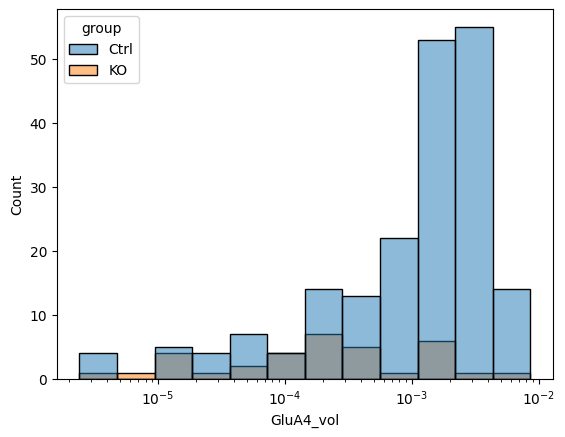

In [43]:
sns.histplot(data, x='GluA4_vol', hue='group',log_scale=True)

<Axes: ylabel='GluA4_vol'>

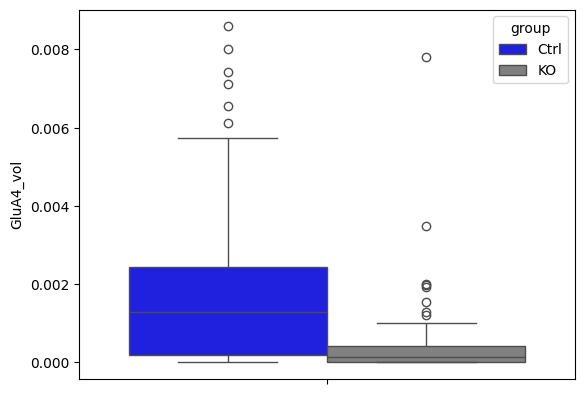

In [44]:
sns.boxplot(data, y="GluA4_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='GluA4_meanint_refnorm'>

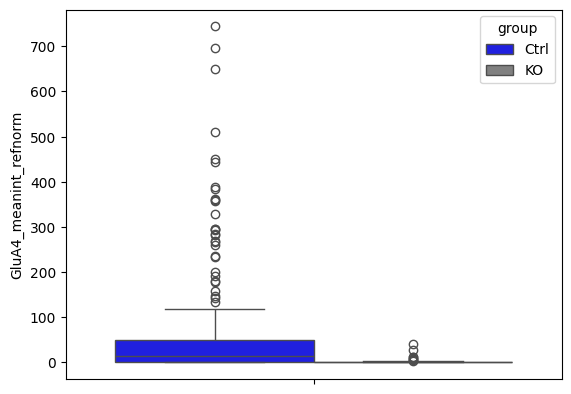

In [45]:
sns.boxplot(data, y="GluA4_meanint_refnorm", hue="group",palette=['blue','gray'])

### 2. Stg

<Axes: xlabel='Stg_vol', ylabel='Count'>

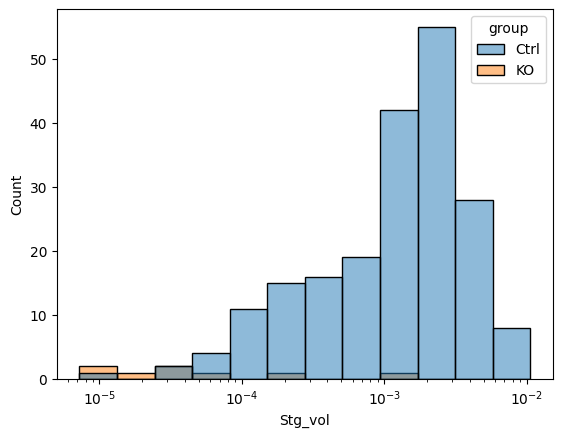

In [46]:
sns.histplot(data, x='Stg_vol', hue='group',log_scale=True)

<Axes: ylabel='Stg_vol'>

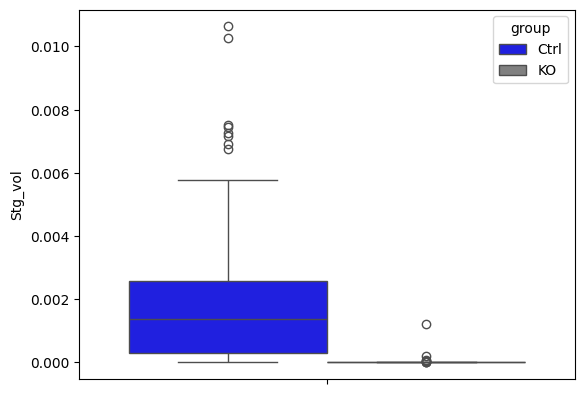

In [47]:
sns.boxplot(data, y="Stg_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='Stg_meanint_refnorm'>

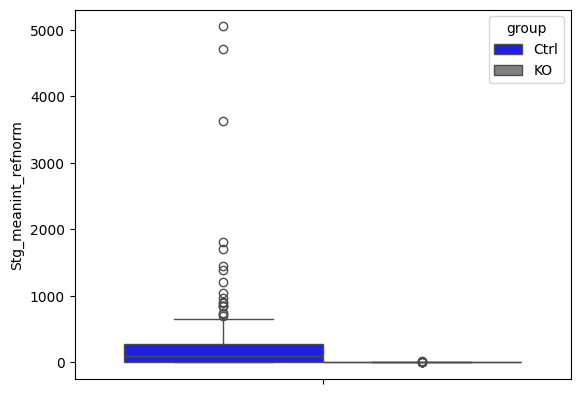

In [48]:
sns.boxplot(data, y="Stg_meanint_refnorm", hue="group",palette=['blue','gray'])

### 3. PSD95

<Axes: xlabel='PSD95_vol', ylabel='Count'>

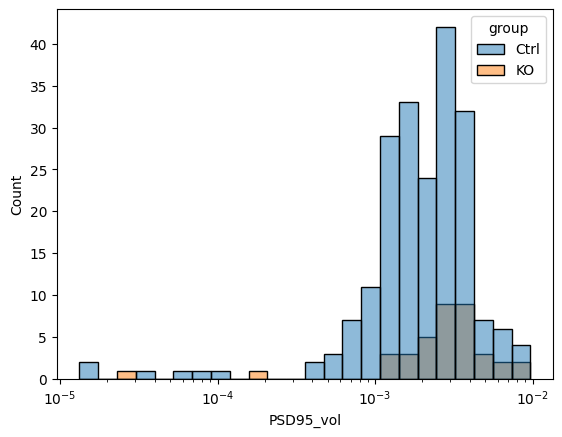

In [49]:
sns.histplot(data, x='PSD95_vol', hue='group',log_scale=True)

<Axes: ylabel='PSD95_vol'>

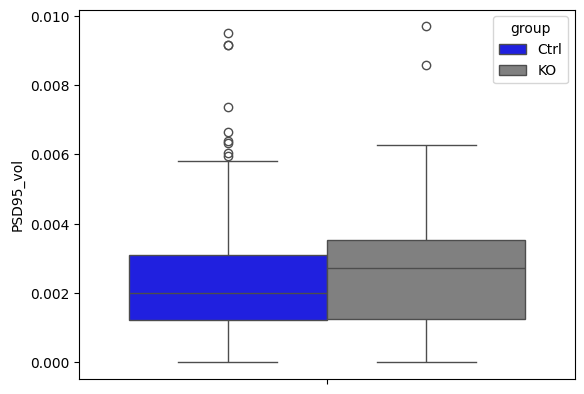

In [50]:
sns.boxplot(data, y="PSD95_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='PSD95_meanint_refnorm'>

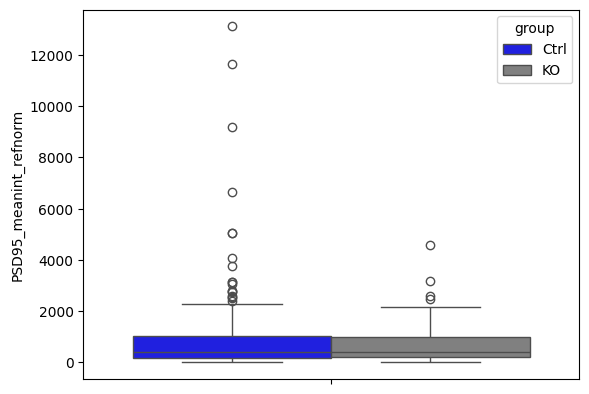

In [51]:
sns.boxplot(data, y="PSD95_meanint_refnorm", hue="group",palette=['blue','gray'])

### 4. GluA3

<Axes: xlabel='GluA3_vol', ylabel='Count'>

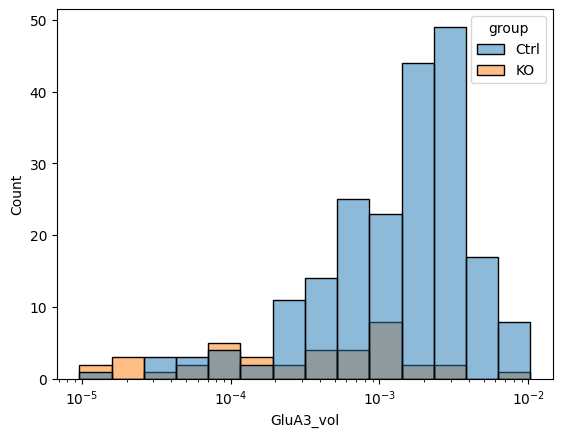

In [52]:
sns.histplot(data, x='GluA3_vol', hue='group',log_scale=True)

<Axes: ylabel='GluA3_vol'>

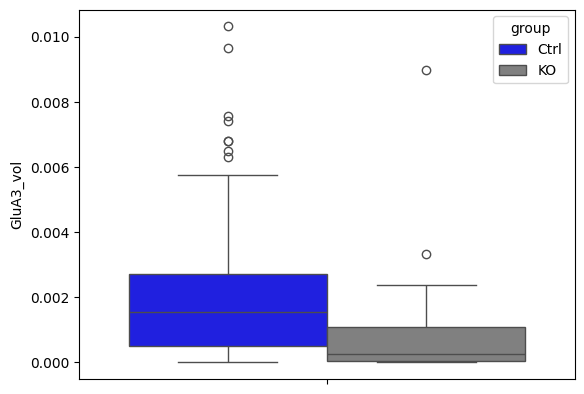

In [53]:
sns.boxplot(data, y="GluA3_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='GluA3_meanint_refnorm'>

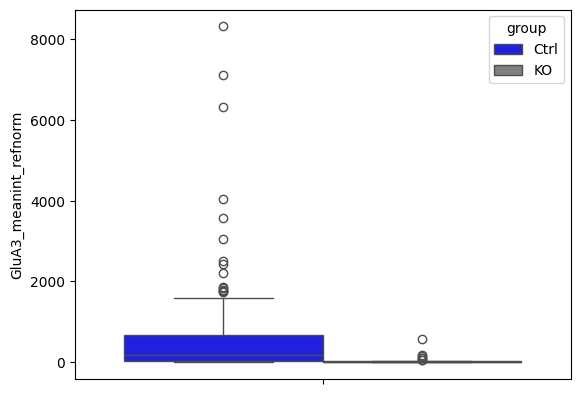

In [54]:
sns.boxplot(data, y="GluA3_meanint_refnorm", hue="group",palette=['blue','gray'])

### 5. NR1

<Axes: xlabel='NR1_vol', ylabel='Count'>

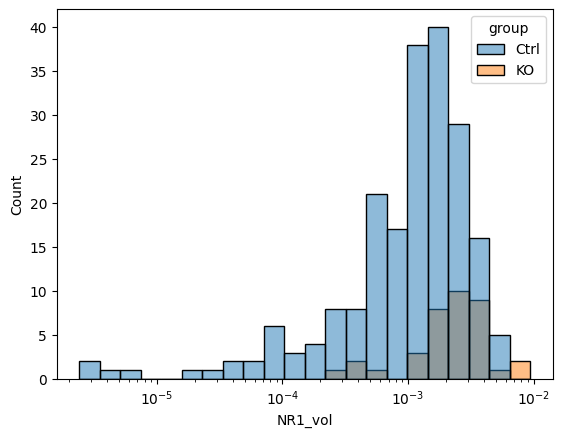

In [55]:
sns.histplot(data, x='NR1_vol', hue='group',log_scale=True)

<Axes: ylabel='NR1_vol'>

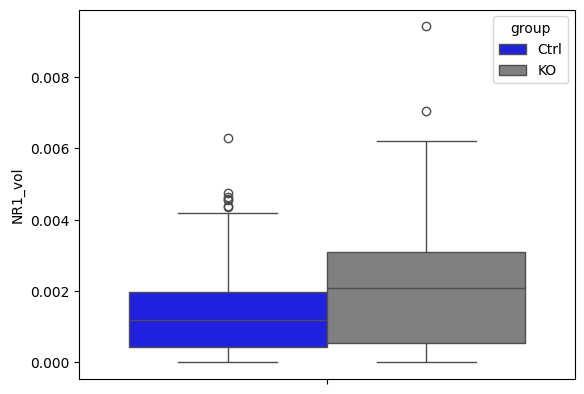

In [56]:
sns.boxplot(data, y="NR1_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='NR1_meanint_refnorm'>

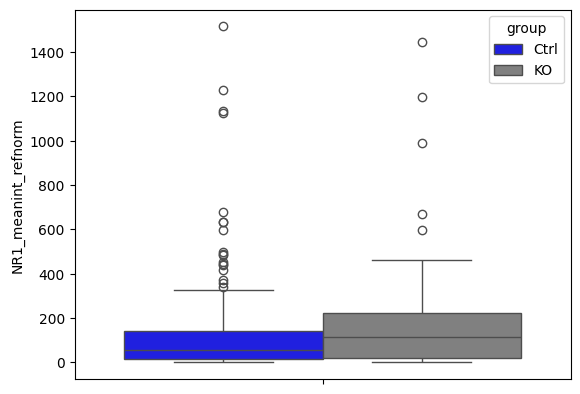

In [57]:
sns.boxplot(data, y="NR1_meanint_refnorm", hue="group",palette=['blue','gray'])

# Test for statistically significant differences in these properties between synapse types

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [59]:
list(data)

['GluA4_vol',
 'GluA3_vol',
 'Stg_vol',
 'PSD95_vol',
 'NR1_vol',
 'GluA4_meanint',
 'GluA3_meanint',
 'Stg_meanint',
 'PSD95_meanint',
 'NR1_meanint',
 'GluA4_meanint_refnorm',
 'GluA3_meanint_refnorm',
 'Stg_meanint_refnorm',
 'PSD95_meanint_refnorm',
 'NR1_meanint_refnorm',
 'selected_tf',
 'sample',
 'fov',
 'syn',
 'group',
 'selected_group']

In [60]:
#approximate new alpha?
0.05 / (6*4)

0.0020833333333333333

In [61]:
unadjusted_pvals = []
zscores = []

### 1. GluA4

In [62]:
# Run mixed lm for target
md = smf.mixedlm("GluA4_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA4_vol
No. Observations: 268     Method:             REML     
No. Groups:       6       Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     1335.1115
Max. group size:  87      Converged:          Yes      
Mean group size:  44.7                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.002    0.000  7.126 0.000  0.001  0.002
group[T.KO]  -0.001    0.000 -4.038 0.000 -0.002 -0.001
Group Var     0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [63]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.0319868351083667e-12
5.392915334222008e-05


In [64]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("GluA4_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA4_meanint_refnorm
No. Observations: 268     Method:             REML                 
No. Groups:       6       Scale:              10064.1972           
Min. group size:  11      Log-Likelihood:     -1612.8946           
Max. group size:  87      Converged:          Yes                  
Mean group size:  44.7                                             
--------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|   [0.025   0.975]
--------------------------------------------------------------------
Intercept          42.375    20.084   2.110  0.035    3.010   81.739
group[T.KO]       -54.430    17.666  -3.081  0.002  -89.054  -19.805
Group Var        1996.643    14.074                                 



In [65]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.03487285814062616
0.0020625538738761307


### 2. Stg

In [66]:
# Run mixed lm for target
md = smf.mixedlm("Stg_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Stg_vol  
No. Observations: 268     Method:             REML     
No. Groups:       6       Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     1318.3804
Max. group size:  87      Converged:          Yes      
Mean group size:  44.7                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.002    0.000  8.346 0.000  0.001  0.002
group[T.KO]  -0.002    0.000 -6.016 0.000 -0.002 -0.001
Group Var     0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.04819036101681e-17
1.7823066073413667e-09


In [68]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("Stg_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Stg_meanint_refnorm
No. Observations: 268     Method:             REML               
No. Groups:       6       Scale:              276988.8369        
Min. group size:  11      Log-Likelihood:     -2049.8581         
Max. group size:  87      Converged:          Yes                
Mean group size:  44.7                                           
------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|   [0.025    0.975] 
------------------------------------------------------------------
Intercept     258.663    46.615   5.549  0.000   167.299   350.026
group[T.KO]  -281.593    91.441  -3.080  0.002  -460.814  -102.372
Group Var    4129.761    13.694                                   



In [69]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.8742618173474874e-08
0.0020733921154285012


### 4. PSD95

In [70]:
# Run mixed lm for target
md = smf.mixedlm("PSD95_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PSD95_vol
No. Observations: 268     Method:             REML     
No. Groups:       6       Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     1315.6302
Max. group size:  87      Converged:          Yes      
Mean group size:  44.7                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.002    0.000 8.030 0.000  0.002  0.003
group[T.KO]    0.000    0.000 0.728 0.466 -0.000  0.001
Group Var      0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [71]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

9.75687545156328e-16
0.4664139837373671


In [72]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("PSD95_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PSD95_meanint_refnorm
No. Observations: 268     Method:             REML                 
No. Groups:       6       Scale:              2033369.3317         
Min. group size:  11      Log-Likelihood:     -2317.6432           
Max. group size:  87      Converged:          Yes                  
Mean group size:  44.7                                             
--------------------------------------------------------------------
               Coef.     Std.Err.    z     P>|z|   [0.025    0.975] 
--------------------------------------------------------------------
Intercept       874.485   220.445   3.967  0.000   442.421  1306.549
group[T.KO]    -403.821   255.168  -1.583  0.114  -903.941    96.299
Group Var    212115.402   123.103                                   



In [73]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.280969029512645e-05
0.11351988308109306


### 5. GluA3

In [74]:
# Run mixed lm for target
md = smf.mixedlm("GluA3_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA3_vol
No. Observations: 268     Method:             REML     
No. Groups:       6       Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     1314.2836
Max. group size:  87      Converged:          Yes      
Mean group size:  44.7                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.002    0.000  8.069 0.000  0.001  0.002
group[T.KO]  -0.001    0.000 -4.174 0.000 -0.002 -0.001
Group Var     0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [75]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.104497630429273e-16
2.9967904592446908e-05


In [76]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("GluA3_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA3_meanint_refnorm
No. Observations: 268     Method:             REML                 
No. Groups:       6       Scale:              844343.8025          
Min. group size:  11      Log-Likelihood:     -2198.3431           
Max. group size:  87      Converged:          Yes                  
Mean group size:  44.7                                             
--------------------------------------------------------------------
                Coef.    Std.Err.    z     P>|z|   [0.025    0.975] 
--------------------------------------------------------------------
Intercept       523.717    86.932   6.024  0.000   353.334   694.101
group[T.KO]    -539.415   159.128  -3.390  0.001  -851.300  -227.529
Group Var     16475.180    27.476                                   



In [77]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.696783211714067e-09
0.0006994005153690252


### 6. Stg

In [78]:
# Run mixed lm for target
md = smf.mixedlm("NR1_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NR1_vol  
No. Observations: 268     Method:             REML     
No. Groups:       6       Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     1380.9183
Max. group size:  87      Converged:          Yes      
Mean group size:  44.7                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.001    0.000 9.168 0.000  0.001  0.002
group[T.KO]    0.001    0.000 2.968 0.003  0.000  0.001
Group Var      0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [79]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.815768047234893e-20
0.002993092217449532


In [80]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("NR1_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NR1_meanint_refnorm
No. Observations: 268     Method:             REML               
No. Groups:       6       Scale:              49262.6167         
Min. group size:  11      Log-Likelihood:     -1820.7338         
Max. group size:  87      Converged:          Yes                
Mean group size:  44.7                                           
------------------------------------------------------------------
                  Coef.    Std.Err.    z    P>|z|  [0.025   0.975]
------------------------------------------------------------------
Intercept         124.350    22.288  5.579  0.000  80.667  168.033
group[T.KO]        76.059    39.834  1.909  0.056  -2.015  154.133
Group Var        1271.278     7.477                               



In [81]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.4143015741944688e-08
0.05621471772689115


#### Compile p-values

In [82]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
    'Stg_vol',
    'Stg_meanint_refnorm',
    'PSD95_vol',
    'PSD95_meanint_refnorm',
    'GluA3_vol',
    'GluA3_meanint_refnorm',
    'NR1_vol',
    'NR1_meanint_refnorm'
]

In [83]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [84]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [85]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'trn_KOvsCtrl_selectedsynapses_lmer_pvals.csv')

In [86]:
prots = ['GluA4','Stg','PSD95','GluA3','NR1']

In [87]:
values = ['vol','meanint_refnorm']

In [88]:
group_colors = ['blue','gray']

In [89]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA4_vol,5.392915e-05,-4.038,1.797638e-04,True
GluA4_meanint_refnorm,2.062554e-03,-3.081,3.455654e-03,True
Stg_vol,1.782307e-09,-6.016,1.782307e-08,True
Stg_meanint_refnorm,2.073392e-03,-3.080,3.455654e-03,True
PSD95_vol,4.664140e-01,0.728,4.664140e-01,False
PSD95_meanint_refnorm,1.135199e-01,-1.583,1.261332e-01,False
GluA3_vol,2.996790e-05,-4.174,1.498395e-04,True
GluA3_meanint_refnorm,6.994005e-04,-3.390,1.748501e-03,True
NR1_vol,2.993092e-03,2.968,4.275846e-03,True
NR1_meanint_refnorm,5.621472e-02,1.909,7.026840e-02,False


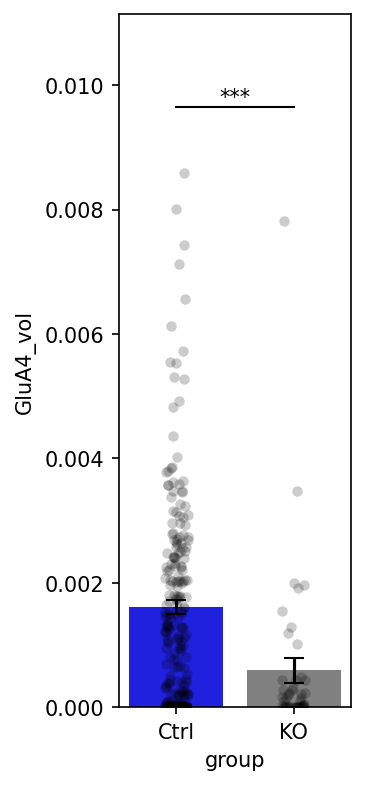

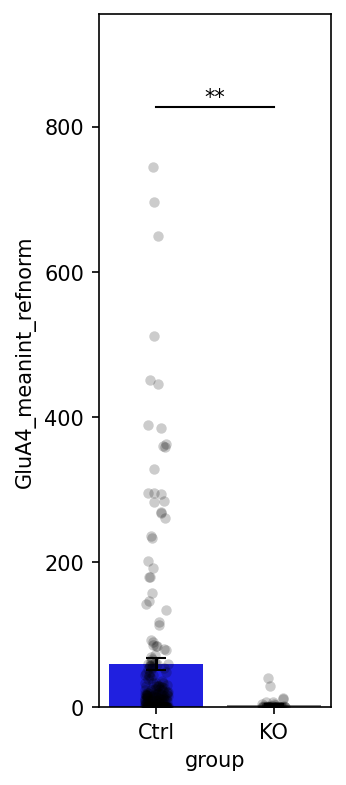

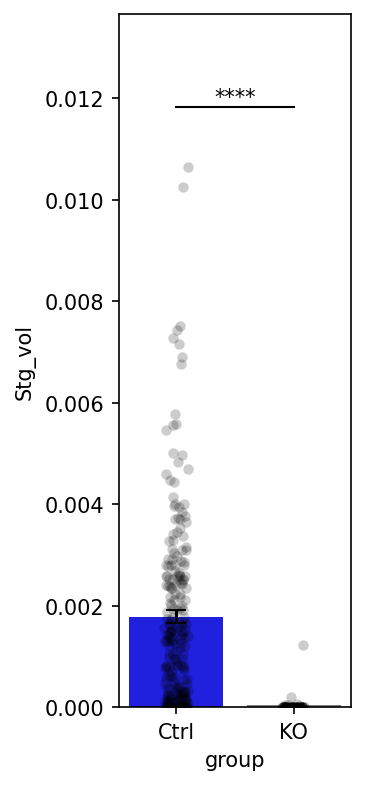

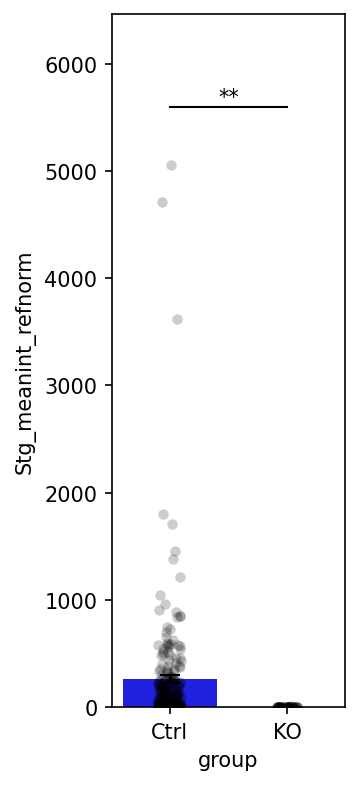

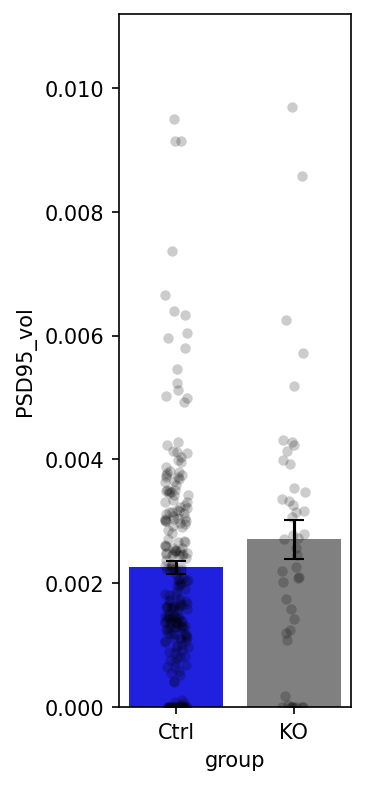

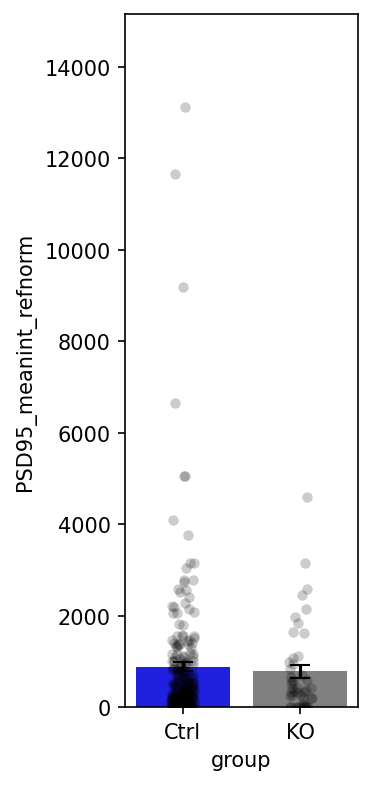

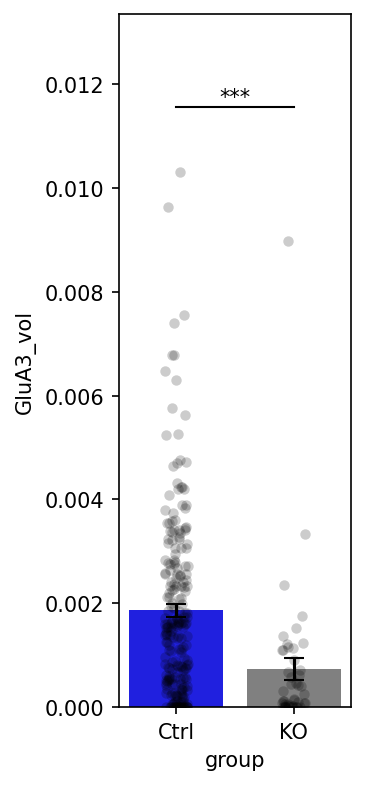

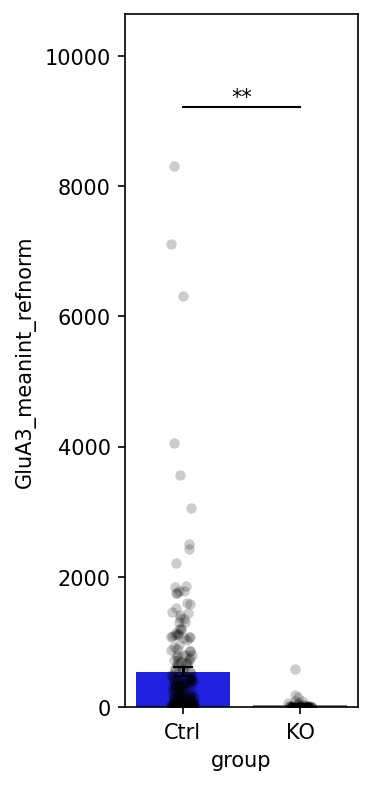

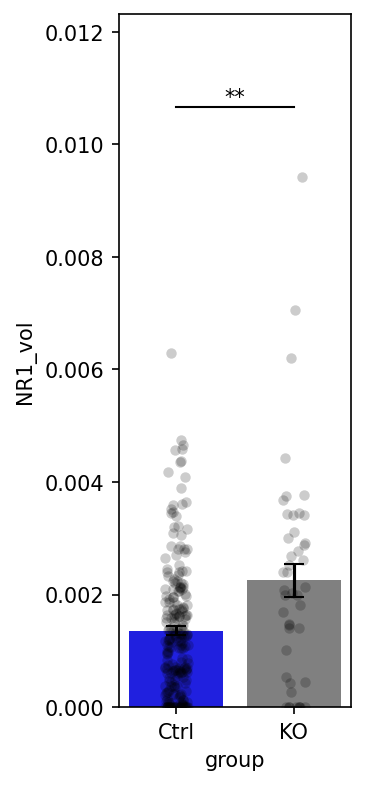

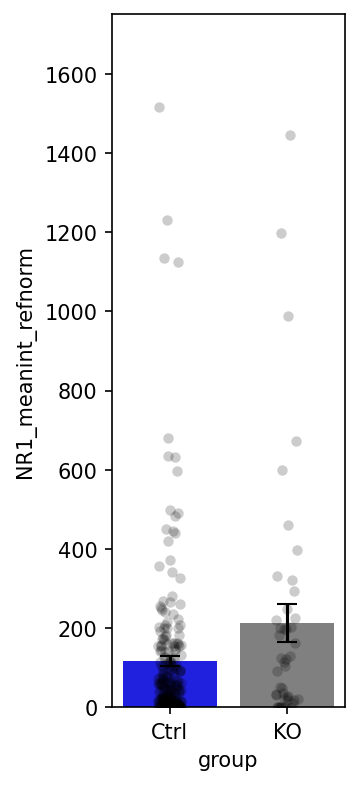

In [91]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your dataFrame with data is named 'data'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data'

# Example dataFrames (uncomment and adjust according to your actual data)
# data = pd.read_csv('your_data.csv')
# pvals_df = pd.read_csv('your_significance_data.csv')

# Identify numerical columns in 'data'
numerical_columns = data.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for val in values:
        col = prot + '_' + val
        data_temp = data
        plt.figure(figsize=(2,6),dpi=150)
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/trn_barplots_selected/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/trn_barplots_selected/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()